# Detecting Hand Drawn Graphs

## Detecting vertices (corners)

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Sample Image

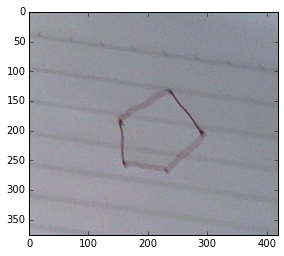

In [3]:
img=cv2.imread("/Users/vigneshm/Documents/pictures/pentagon-graph.jpg")
plt.imshow(img)

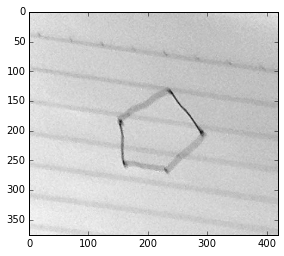

In [4]:
img_bw=cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
plt.imshow(img_bw,cmap='gray')

Corners using Harris

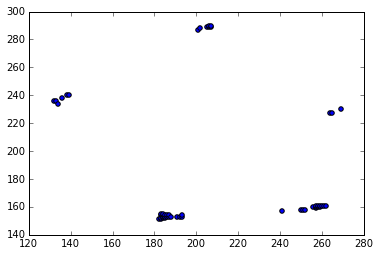

In [5]:
corners=cv2.cornerHarris(img_bw,2,5,0.04)
valid_c_x,valid_c_y=np.where(corners>0.1*corners.max())
plt.scatter(valid_c_x,valid_c_y)

Getting many corners and distance clustering

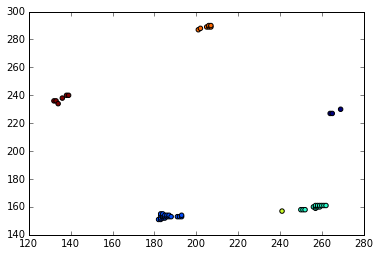

In [6]:
from scipy.cluster.hierarchy import fclusterdata
clusters=fclusterdata(np.transpose((valid_c_x,valid_c_y)),5,criterion='distance')
plt.scatter(valid_c_x,valid_c_y,c=clusters)

[266 228] 3
[186 153] 21
[256 159] 14
discarding  [34]
[204 288] 7
[135 237] 6


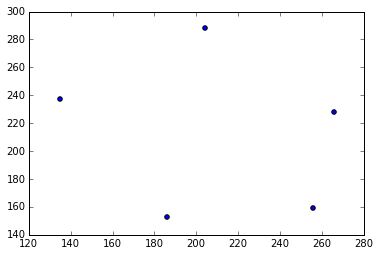

In [7]:
clustered_c=[]
for code in range(1,clusters.max()+1):
    code_corners=np.where(clusters==code)[0]
    if(code_corners.size<3):
        print 'discarding ',code_corners
    else:
        meanpos=np.array([int(valid_c_x[code_corners].mean()),int(valid_c_y[code_corners].mean())])
        print meanpos,code_corners.size
        clustered_c.append(meanpos)
clustered_c=np.array(clustered_c)
plt.scatter(clustered_c[...,0],clustered_c[...,1])

### Detecting straight edges between vertices

In [8]:
def check_connected_rect(p1,p2,tol=1):
    slope=p2-p1
    width=np.linalg.norm(slope)
    slope=slope/np.linalg.norm(slope)
    perp=np.cross(slope,(0,0,1))[0:2]
    area=[]
    for x in np.arange(-tol,tol+1):
        area.append([p1+slope*m+x for m in np.arange(width)])
    area=np.array(area,dtype=int)
    rect=img_bw[area[...,0],area[...,1]]
    return rect.sum()/(255*rect.size)

In [12]:
ret,img_thresh=cv2.threshold(img_bw,130,255,cv2.THRESH_BINARY_INV)
kernel=cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
img_morph=cv2.morphologyEx(img_thresh,cv2.MORPH_CLOSE,kernel)

In [41]:
from itertools import combinations
edges=[]
for p1,p2 in combinations(clustered_c,2):
    ch=check_connected_rect(p1,p2)
    if ch>0.2: # has to be approx more than .33
        edges.append((p1,p2,ch))
edges=np.array(edges)

[[array([266, 228]) array([256, 159]) 0.59999999999999998]
 [array([266, 228]) array([204, 288]) 0.37164750957854409]
 [array([186, 153]) array([256, 159]) 0.92488262910798125]
 [array([186, 153]) array([135, 237]) 0.45791245791245794]
 [array([204, 288]) array([135, 237]) 0.86434108527131781]]


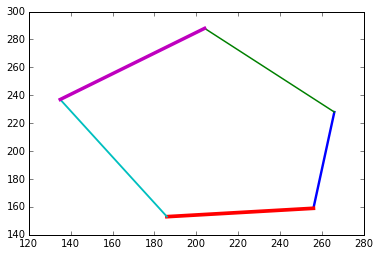

In [42]:
for p1,p2,ch in edges:
    plt.plot([p1[0],p2[0]],[p1[1],p2[1]],linewidth=4*ch)
print edges